Per Chapter 5 of Chollet's _Deep Learning with Python_, we've trained a simple dog/cat CNN classifier.

In [1]:
%pylab inline

import helpers
from keras.models import load_model
from keras import models
from keras.utils import plot_model

model = load_model('cats_and_dogs_small_2.h5')

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


Now, we want to understand why this "black box algorithm" makes the determinations that it does.

We'll do this by loading up a sample image, show it to the Network, then inspect how the different components react to the data it sees.

## Image Preprocessing

First things first, here's a cat.

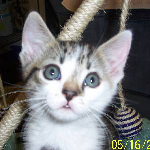

In [2]:
img_path = 'images/cat.jpg'

from keras.preprocessing import image

img_tensor = image.load_img(img_path, target_size=(150, 150))
img_tensor

Of course, we'll need to go from image to numerical representation. The following gives us a vector of shape `(height, width, channels)`

In [3]:
img_tensor = image.img_to_array(img_tensor)
img_tensor.shape

(150, 150, 3)

But the model expects an input with 4 dimensions (specifically with arbitrarily-many records for the first dimension)

In [4]:
model.input.shape

TensorShape([Dimension(None), Dimension(150), Dimension(150), Dimension(3)])

So we'll transform appropriately with `np.expand_dims`

In [17]:
img_tensor = np.expand_dims(img_tensor, axis=0)

img_tensor.shape

(1, 1, 150, 150, 3)

Furthermore, the RGB values for the image are comprised of values between 0 and 255

In [6]:
img_tensor.min(), img_tensor.max()

(0.0, 255.0)

But as we know from the various optimization notebooks we've written/read, normalizing our values to be between `0` and `1` helps speed up training due to faster convergence.

In [7]:
img_tensor /= 255.

Finally, our image vector is good to go.

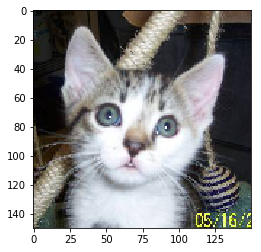

In [8]:
plt.imshow(img_tensor[0]);

## Cracking the Network Open

So we've got this stacked model with a bunch of layers

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 15, 15, 128)       147584    
__________

We don't care about the last 4 layers because they're used for the actual consolidation/prediction and can't be neatly traced back to the image itself.

In [10]:
layer_outputs = [layer.output for layer in model.layers[:8]]
layer_outputs

[<tf.Tensor 'conv2d_21/Relu:0' shape=(?, 148, 148, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d_21/MaxPool:0' shape=(?, 74, 74, 32) dtype=float32>,
 <tf.Tensor 'conv2d_22/Relu:0' shape=(?, 72, 72, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_22/MaxPool:0' shape=(?, 36, 36, 64) dtype=float32>,
 <tf.Tensor 'conv2d_23/Relu:0' shape=(?, 34, 34, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_23/MaxPool:0' shape=(?, 17, 17, 128) dtype=float32>,
 <tf.Tensor 'conv2d_24/Relu:0' shape=(?, 15, 15, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_24/MaxPool:0' shape=(?, 7, 7, 128) dtype=float32>]

In [11]:
type(layer_outputs[0])

tensorflow.python.framework.ops.Tensor

So what we're going to do is make a generic `Model` that takes an image as its input, and returns each output `Tensor` at every step of the Network.

In [12]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

Not only does each layer flow into the next to seed *their* activations, it also kicks out the activation values, a matrix, that can be coerced into a human-interpretable image.

In [13]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

In [14]:
activations = activation_model.predict(img_tensor)

Because the first 8 layers alternate between Convolution and MaxPooling, we're only going to take every other element-- the results of Pooling aren't terribly interesting/novel to inspect.

This code chunk handles that.

In [15]:
from itertools import islice

chunk = islice(zip(layer_names, activations), 0, None, 2)

Finally, we borrow, almost verbatim, from Chollet to iterate through all of these activation matricies and plot the results, by layer

C:\Users\Nick\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


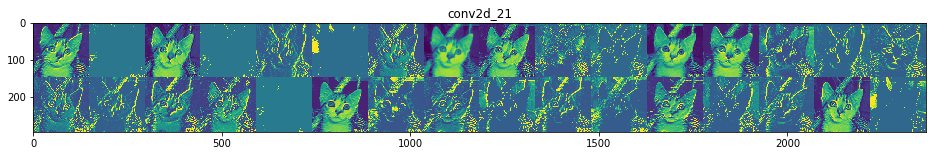

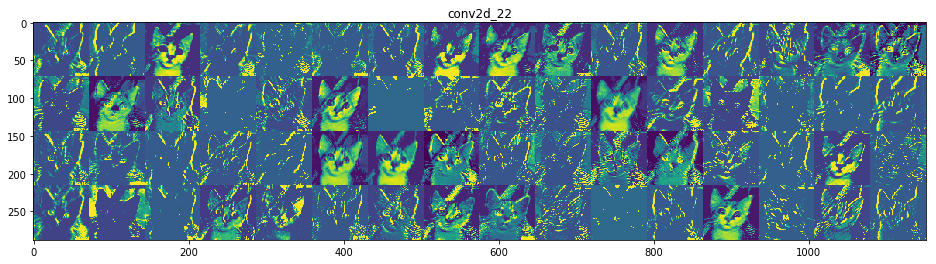

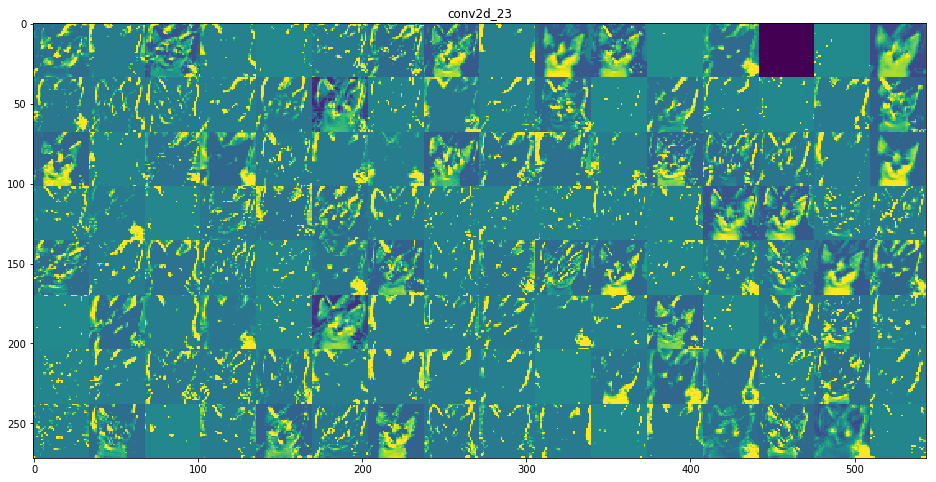

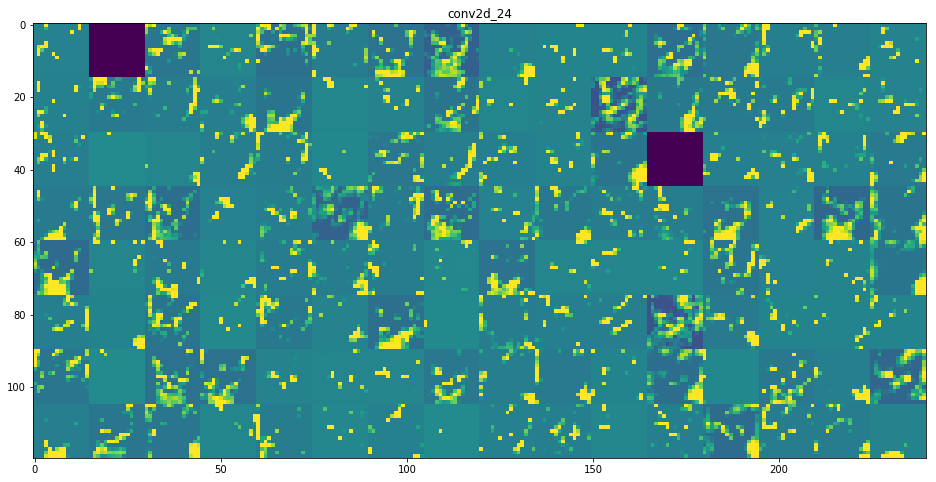

In [16]:
images_per_row = 16

for layer_name, layer_activation in chunk:
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                              :, :,
                                              col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
            display_grid[col * size : (col+1) * size,
                         row * size : (row+1) * size] = channel_image
            
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Finally, as remarked [in our notebook about Convolution](https://napsterinblue.github.io/notes/machine_learning/computer_vision/conv_intuition/), you can clearly see here that the deeper into the Network we inspect:

1. The more filters we employ to capture high-level features
2. The blurrier and more-general these high-level features look